In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
len(glob("res_tmp_depth4/*/*.csv"))

579

In [3]:
dfs = []
trees = []
for filename in tqdm(glob("res_tmp_depth4/*/*.csv")):
    dfs.append(pd.read_csv(filename))
    dfs[-1]['dataset'] = filename.split('/')[1]
    with open(filename.replace('.csv', '.pickle'), 'rb') as f:
        trees.append(pickle.load(f))

  0%|          | 0/579 [00:00<?, ?it/s]

In [4]:
lista_dataset = [
    'iris',
    'vertebral',
    'home',
    'auction',
    'seeds',
    'ecoli',
    'bankMarketing',
    'magic',
    'diabetes',
    'titanic',
    'glass', 
    'covertype'
]

marker_HDT = 'o' #'o'
marker_ONLY = 's' #r'$1$'
marker_no = '^' #'_'
marker_no_family = '*' # 'x'

colors = ['#e41a1c','#377eb8','#4daf4a','#ffff33','#ff7f00','#984ea3','#a65628','#f781bf','#999999']

viz_dict = {
    'HDT': (r'$\mathrm{HDT}$', marker_HDT, 'black'),
    
    'ONLY_Decision': (r'$\mathrm{UDT}$', marker_ONLY, colors[0]),
    'ONLY_ObliqueDecision': (r'$\mathrm{ODT}$', marker_ONLY, colors[1]),
    'ONLY_Pivot': (r'$\mathrm{PT}$', marker_ONLY, colors[2]),
    'ONLY_MultiplePivot': (r'$\mathrm{PPT}$', marker_ONLY, colors[3]),
    'ONLY_PartialPivot': (r'$\mathrm{SPT}$', marker_ONLY, colors[4]),
    'ONLY_PartialProximity': (r'$\mathrm{SPPT}$', marker_ONLY, colors[5]),

    'HDT_no_DecisionTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{UD}}$', marker_no, colors[0]),
    'HDT_no_ObliqueDecisionTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{OD}}$', marker_no, colors[1]),
    'HDT_no_PivotTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{P}}$', marker_no, colors[2]),
    'HDT_no_MultiplePivotTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{PP}}$', marker_no, colors[3]),
    'HDT_no_PartialPivotTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{SP}}$', marker_no, colors[4]),
    'HDT_no_PartialProximityTreeStumpClassifier': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{SPP}}$', marker_no, colors[5]),

    'HDT_no_classic': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{UD}, \mathrm{OD}}$', marker_no_family, colors[0]),
    'HDT_no_pivot': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{P}, \mathrm{PP}}$', marker_no_family, colors[1]),
    'HDT_no_partial': (r'$\mathrm{HDT}^{\, - \,}_{\mathrm{SP}, \mathrm{SPP}}$', marker_no_family, colors[2]),
}

## Count stump

In [5]:
def list_stump(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    return [node.stump.__class__.__name__] + list_stump(node.node_l) + list_stump(node.node_r)

In [6]:
trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump(tree.root))

In [7]:
all_available_stumps = set()

for stump_list in trees_stumps:
    all_available_stumps |= set(stump_list)

In [8]:
all_available_stumps

{'DecisionTreeStumpClassifier',
 'MultiplePivotTreeStumpClassifier',
 'ObliqueDecisionTreeStumpClassifier',
 'PartialPivotTreeStumpClassifier',
 'PartialProximityTreeStumpClassifier',
 'PivotTreeStumpClassifier'}

In [9]:
count = []
for used_stumps in trees_stumps:
    c = {s: used_stumps.count(s) for s in all_available_stumps}
    count.append(c)

df_count = pd.DataFrame(count)
df_count.rename(columns={x: x.replace('TreeStumpClassifier', '') for x in df_count.columns}, inplace=True)

In [10]:
df_count

,ObliqueDecision,Pivot,MultiplePivot,PartialProximity,PartialPivot,Decision
0,0,0,1,0,8,3
1,0,6,0,1,1,2
2,1,0,0,1,6,3
3,0,5,0,2,1,1
4,0,5,0,0,2,3
...,...,...,...,...,...,...
574,3,4,0,0,1,0
575,0,3,0,1,0,4
576,0,2,0,0,2,3
577,0,0,10,0,0,0


## Count stump weight

In [11]:
def list_stump_w(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    return [(node.stump.__class__.__name__, 1/depth)] + list_stump_w(node.node_l, depth+1) + list_stump_w(node.node_r, depth+1)

trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump_w(tree.root))

count_w = []
for used_stumps in trees_stumps:
    c = dict()
    for stump_to_check in all_available_stumps:
        c[stump_to_check] = 0
        for stump_name, w in used_stumps:
            if stump_to_check == stump_name:
                c[stump_name] += w
    
    #c = {s: used_stumps.sum(s) for s in all_available_stumps}
    count_w.append(c)

df_count_w = pd.DataFrame(count_w)
df_count_w.rename(columns={x: x.replace('TreeStumpClassifier', '')+'_w' for x in df_count_w.columns}, inplace=True)

df_count_w

,ObliqueDecision_w,Pivot_w,MultiplePivot_w,PartialProximity_w,PartialPivot_w,Decision_w
0,0.00,0.000000,0.5,0.000000,3.250000,0.750000
1,0.00,1.916667,0.0,0.500000,1.000000,0.666667
2,0.25,0.000000,0.0,1.000000,2.166667,0.833333
3,0.00,1.666667,0.0,1.500000,0.250000,0.333333
4,0.00,1.916667,0.0,0.000000,0.583333,1.500000
...,...,...,...,...,...,...
574,0.75,2.083333,0.0,0.000000,0.333333,0.000000
575,0.00,1.833333,0.0,0.333333,0.000000,1.000000
576,0.00,1.000000,0.0,0.000000,1.333333,0.833333
577,0.00,0.000000,4.0,0.000000,0.000000,0.000000


In [12]:
from RuleTree.utils.data_utils import get_info_gain

def list_stump_w_info(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    return [(node.stump.__class__.__name__, get_info_gain(node.stump))] + list_stump_w(node.node_l, depth+1) + list_stump_w(node.node_r, depth+1)

trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump_w_info(tree.root))

count_w_info = []
for used_stumps in trees_stumps:
    c = dict()
    for stump_to_check in all_available_stumps:
        c[stump_to_check] = 0
        for stump_name, w in used_stumps:
            if stump_to_check == stump_name:
                c[stump_name] += w
    
    #c = {s: used_stumps.sum(s) for s in all_available_stumps}
    count_w_info.append(c)

df_count_w_info = pd.DataFrame(count_w_info)
df_count_w_info.rename(columns={x: x.replace('TreeStumpClassifier', '')+'_w_info' for x in df_count_w_info.columns}, inplace=True)

df_count_w_info

,ObliqueDecision_w_info,Pivot_w_info,MultiplePivot_w_info,PartialProximity_w_info,PartialPivot_w_info,Decision_w_info
0,0.00,0.000000,0.500000,0.000000,2.594272,0.750000
1,0.00,1.916667,0.000000,0.500000,0.339529,0.666667
2,0.25,0.000000,0.000000,0.344272,2.166667,0.833333
3,0.00,1.666667,0.000000,0.844272,0.250000,0.333333
4,0.00,1.916667,0.000000,0.000000,0.583333,0.839228
...,...,...,...,...,...,...
574,0.75,1.390580,0.000000,0.000000,0.333333,0.000000
575,0.00,1.140580,0.000000,0.333333,0.000000,1.000000
576,0.00,1.000000,0.000000,0.000000,0.649128,0.833333
577,0.00,0.000000,3.275328,0.000000,0.000000,0.000000


In [13]:
from RuleTree.utils.data_utils import get_info_gain

def list_stump_w_imp(node, depth=1):
    if not hasattr(node, 'stump') or node.stump is None:
        return []
    samples = node.samples
    samples_l = node.node_l.samples
    samples_r = node.node_r.samples
    impurity, impurity_l, impurity_r = tree.root.stump.tree_.impurity
    impurity_decrease = impurity - (samples_l*impurity_l + samples_r*impurity_r)/samples
    
    return [(node.stump.__class__.__name__, impurity_decrease * samples)] + list_stump_w(node.node_l, depth+1) + list_stump_w(node.node_r, depth+1)

trees_stumps = []
for tree in trees:
    trees_stumps.append(list_stump_w_imp(tree.root))

count_w_imp = []
for used_stumps in trees_stumps:
    c = dict()
    for stump_to_check in all_available_stumps:
        c[stump_to_check] = 0
        for stump_name, w in used_stumps:
            if stump_to_check == stump_name:
                c[stump_name] += w
    
    #c = {s: used_stumps.sum(s) for s in all_available_stumps}
    count_w_imp.append(c)

df_count_w_imp = pd.DataFrame(count_w_imp)
df_count_w_imp.rename(columns={x: x.replace('TreeStumpClassifier', '')+'_w_imp' for x in df_count_w_imp.columns}, inplace=True)

df_count_w_imp

,ObliqueDecision_w_imp,Pivot_w_imp,MultiplePivot_w_imp,PartialProximity_w_imp,PartialPivot_w_imp,Decision_w_imp
0,0.00,0.000000,0.500000,0.000000,87.629335,0.750000
1,0.00,1.916667,0.000000,0.500000,84.203192,0.666667
2,0.25,0.000000,0.000000,85.379335,2.166667,0.833333
3,0.00,1.666667,0.000000,85.879335,0.250000,0.333333
4,0.00,1.916667,0.000000,0.000000,0.583333,84.628460
...,...,...,...,...,...,...
574,0.75,52.700725,0.000000,0.000000,0.333333,0.000000
575,0.00,52.450725,0.000000,0.333333,0.000000,1.000000
576,0.00,1.000000,0.000000,0.000000,53.386905,0.833333
577,0.00,0.000000,49.255097,0.000000,0.000000,0.000000


In [14]:
tree.root.stump.tree_.impurity

array([0.66666667, 0.03570248, 0.51719007])

## Ablation study

In [15]:
df = pd.concat(dfs, ignore_index=True)

df[df_count.columns] = df_count.values
df[df_count_w.columns] = df_count_w.values
df[df_count_w_info.columns] = df_count_w_info.values
df[df_count_w_imp.columns] = df_count_w_imp.values

df

,max_depth,prune_useless_leaves,stump_selection,random_state,splitter,base_stumps,distance_measure,method,DecisionTreeStumpClassifier,ObliqueDecisionTreeStumpClassifier,...,MultiplePivot_w_info,PartialProximity_w_info,PartialPivot_w_info,Decision_w_info,ObliqueDecision_w_imp,Pivot_w_imp,MultiplePivot_w_imp,PartialProximity_w_imp,PartialPivot_w_imp,Decision_w_imp
0,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_PivotTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.500000,0.000000,2.594272,0.750000,0.00,0.000000,0.500000,0.000000,87.629335,0.750000
1,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_MultiplePivotTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.500000,0.339529,0.666667,0.00,1.916667,0.000000,0.500000,84.203192,0.666667
2,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_pivot,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.344272,2.166667,0.833333,0.25,0.000000,0.000000,85.379335,2.166667,0.833333
3,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_MultiplePivotTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.844272,0.250000,0.333333,0.00,1.666667,0.000000,85.879335,0.250000,0.333333
4,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_PartialProximityTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.000000,0.583333,0.839228,0.00,1.916667,0.000000,0.000000,0.583333,84.628460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,4,True,best,42,best,"['ObliqueDecisionTreeStumpClassifier', 'PivotT...",euclidean,HDT_no_DecisionTreeStumpClassifier,NaN,"{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.000000,0.333333,0.000000,0.75,52.700725,0.000000,0.000000,0.333333,0.000000
575,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'ObliqueDecisi...",euclidean,HDT_no_PartialPivotTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}","{'max_depth': 1, 'random_state': 42, 'oblique_...",...,0.000000,0.333333,0.000000,1.000000,0.00,52.450725,0.000000,0.333333,0.000000,1.000000
576,4,True,best,42,best,"['DecisionTreeStumpClassifier', 'PivotTreeStum...",euclidean,HDT_no_ObliqueDecisionTreeStumpClassifier,"{'max_depth': 1, 'random_state': 42}",NaN,...,0.000000,0.000000,0.649128,0.833333,0.00,1.000000,0.000000,0.000000,53.386905,0.833333
577,4,True,best,42,best,['MultiplePivotTreeStumpClassifier'],euclidean,ONLY_MultiplePivot,NaN,NaN,...,3.275328,0.000000,0.000000,0.000000,0.00,0.000000,49.255097,0.000000,0.000000,0.000000


In [16]:
df_original = df.copy(deep=True)

df = df[df.dataset.isin(lista_dataset)].copy(deep=True)

#df = df_original.copy(deep=True)

In [17]:
for max_depth in sorted(df.max_depth.unique()):
    print(max_depth, 
          round(df[df.max_depth==max_depth].resulting_max_depth_test.min(), 3),
          round(df[df.max_depth==max_depth].resulting_max_depth_test.mean(), 3),
          round(df[df.max_depth==max_depth].resulting_max_depth_test.max(), 3), sep="\t"
         )

4	3	4.974	5


In [18]:
#df_best = df[df.max_depth==5].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)
df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)

df_best_pivot = df_best.pivot(index=['dataset'], columns=['method'], values='f1_macro_test')

df_best_pivot.T.style.background_gradient(cmap='coolwarm')

dataset,auction,bankMarketing,covertype,diabetes,ecoli,glass,home,iris,magic,seeds,titanic,vertebral
method,,,,,,,,,,,,
HDT,0.917388,0.731087,0.757159,0.665762,0.678633,0.456536,0.898148,0.932660,0.844186,0.873056,0.770513,0.823595
HDT_no_DecisionTreeStumpClassifier,0.879336,0.744770,0.742034,0.691503,0.654156,0.507341,0.867824,0.899749,0.631212,0.873056,0.784893,0.759498
HDT_no_MultiplePivotTreeStumpClassifier,0.946408,0.699970,0.739974,0.626004,0.874056,0.435714,0.898148,0.932660,0.517278,0.876628,0.774244,0.782509
HDT_no_ObliqueDecisionTreeStumpClassifier,0.882537,0.729024,0.719972,0.719388,0.643663,0.453170,0.877778,0.966583,0.622731,0.850000,0.754544,0.706532
HDT_no_PartialPivotTreeStumpClassifier,0.902024,0.722484,0.744994,0.683084,0.668429,0.421569,0.898148,0.932660,0.820238,0.873056,0.824278,0.647099
HDT_no_PartialProximityTreeStumpClassifier,0.840789,0.709993,0.750590,0.686296,0.674877,0.472222,0.866729,0.932660,0.678633,0.822401,0.748017,0.814863
HDT_no_PivotTreeStumpClassifier,0.849291,0.693275,0.725000,0.685126,0.880929,0.570194,0.876661,0.932660,0.636937,0.927742,0.728564,0.716940
HDT_no_classic,0.855766,0.722207,0.722290,0.615000,0.694631,0.381481,0.846923,0.966583,0.888112,0.849926,0.701584,0.738889
HDT_no_partial,0.716563,0.741788,0.731761,0.558036,0.641596,0.421569,0.887744,0.966583,0.641596,0.873056,0.794669,0.782509


In [19]:
[viz_dict[x][0] for x in df_best_pivot.columns]

['$\\mathrm{HDT}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{UD}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{PP}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{OD}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{SP}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{SPP}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{P}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{UD}, \\mathrm{OD}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{SP}, \\mathrm{SPP}}$',
 '$\\mathrm{HDT}^{\\, - \\,}_{\\mathrm{P}, \\mathrm{PP}}$',
 '$\\mathrm{UDT}$',
 '$\\mathrm{PPT}$',
 '$\\mathrm{ODT}$',
 '$\\mathrm{SPT}$',
 '$\\mathrm{SPPT}$',
 '$\\mathrm{PT}$']

dataset,auction,bankMarketing,covertype,diabetes,ecoli,glass,home,iris,magic,seeds,titanic,vertebral
method,,,,,,,,,,,,
HDT,0.917388,0.731087,0.757159,0.665762,0.678633,0.456536,0.898148,0.932660,0.844186,0.873056,0.770513,0.823595
HDT_no_DecisionTreeStumpClassifier,0.879336,0.744770,0.742034,0.691503,0.654156,0.507341,0.867824,0.899749,0.631212,0.873056,0.784893,0.759498
HDT_no_MultiplePivotTreeStumpClassifier,0.946408,0.699970,0.739974,0.626004,0.874056,0.435714,0.898148,0.932660,0.517278,0.876628,0.774244,0.782509
HDT_no_ObliqueDecisionTreeStumpClassifier,0.882537,0.729024,0.719972,0.719388,0.643663,0.453170,0.877778,0.966583,0.622731,0.850000,0.754544,0.706532
HDT_no_PartialPivotTreeStumpClassifier,0.902024,0.722484,0.744994,0.683084,0.668429,0.421569,0.898148,0.932660,0.820238,0.873056,0.824278,0.647099
HDT_no_PartialProximityTreeStumpClassifier,0.840789,0.709993,0.750590,0.686296,0.674877,0.472222,0.866729,0.932660,0.678633,0.822401,0.748017,0.814863
HDT_no_PivotTreeStumpClassifier,0.849291,0.693275,0.725000,0.685126,0.880929,0.570194,0.876661,0.932660,0.636937,0.927742,0.728564,0.716940
HDT_no_classic,0.855766,0.722207,0.722290,0.615000,0.694631,0.381481,0.846923,0.966583,0.888112,0.849926,0.701584,0.738889
HDT_no_partial,0.716563,0.741788,0.731761,0.558036,0.641596,0.421569,0.887744,0.966583,0.641596,0.873056,0.794669,0.782509


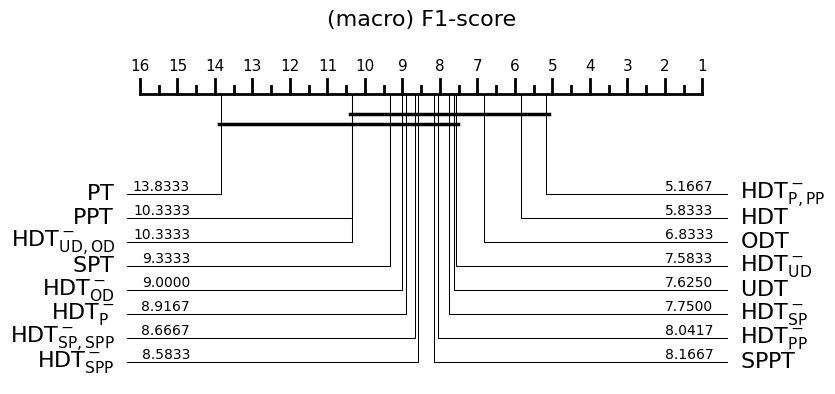

In [20]:
from aeon.visualisation import plot_critical_difference

df_best_pivot.dropna(inplace=True)

display(df_best_pivot.T.style.background_gradient(cmap='coolwarm'))

plot_critical_difference(df_best_pivot[df_best_pivot.columns[::-1]].values, 
                         labels=[viz_dict[x][0].replace('{\\, - \\,}', '-') for x in df_best_pivot.columns][::-1], 
                         lower_better=False, alpha=.1, 
                         test='nemenyi', width=7.5)
plt.title('(macro) F1-score', fontsize=16)
plt.savefig("z_img_2Ablation_depth4_F1.png", dpi=300, bbox_inches='tight')
plt.show()

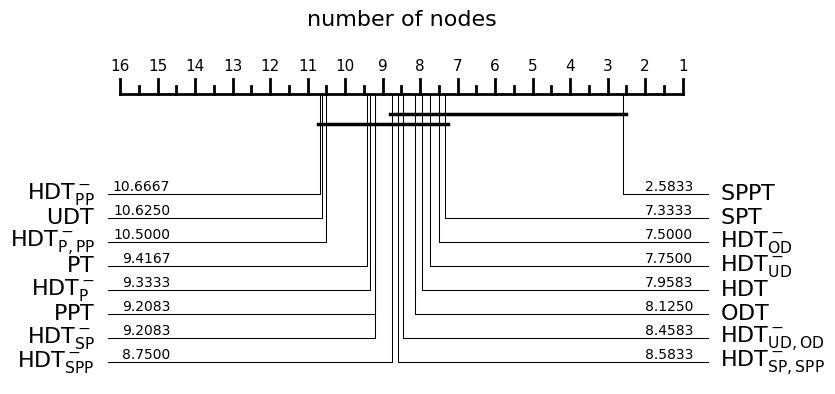

In [21]:
#df_best = df[df.max_depth==5].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)
df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False).groupby(["dataset", "method"]).head(1)

df_best_pivot = df_best.pivot(index=['dataset'], columns=['method'], values='n_nodes_test')

df_best_pivot.T.style.background_gradient(cmap='coolwarm')


plot_critical_difference(df_best_pivot.values, 
                         labels=[viz_dict[x][0].replace('{\\, - \\,}', '-') for x in df_best_pivot.columns], 
                         lower_better=True, alpha=.1, test='nemenyi', width=7.5)
plt.title('number of nodes', fontsize=16)
plt.savefig("z_img_2Ablation_depth4_nodi.png", dpi=300, bbox_inches='tight', )
plt.show()

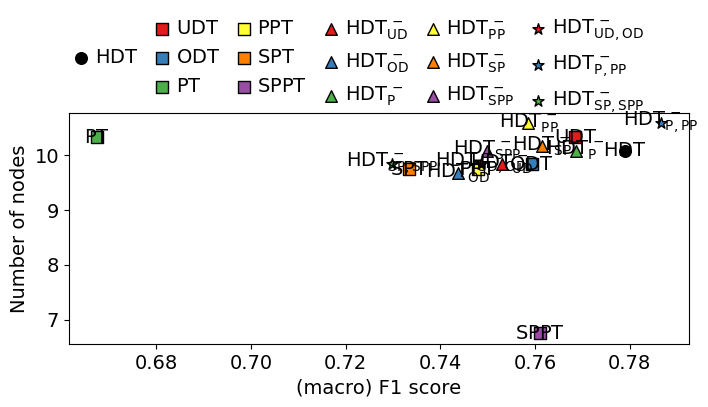

In [22]:
from adjustText import adjust_text

plt.figure(figsize=(8, 3))

y_measure = ['resulting_max_depth_test', 'n_nodes_test', 'n_leaf_test'][1]

df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val', y_measure], ascending=[False]*3+[True])\
            .groupby(["dataset", "method"]).head(1).copy(deep=True)

df_best.resulting_max_depth_test -= 1

df_best = df_best.groupby(by=['method'])[['f1_macro_test', y_measure]].mean().reset_index()

texts = []
for i, method in enumerate(viz_dict.keys()):
    row = df_best[df_best['method'] == method]
    if not row.empty:
        f1_macro = row['f1_macro_test'].values[0]
        n_nodes = row[y_measure].values[0]
        label, marker, color = viz_dict[method]

        if i in [0, 1]:
            plt.scatter(f1_macro, n_nodes, label='$^{ }_{ } $', c='#ffffff')
        
        plt.scatter([f1_macro], 
                    [n_nodes], 
                    marker=(2, 0, 45) if marker == '_' else marker, 
                    label=label, 
                    c=color,
                    s=70,
                    edgecolors='black',
                    linewidths=1
        )
        texts.append(plt.text(f1_macro, n_nodes, label, ha='center', va='center', fontsize=14))

"""adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='black'),
            force_text=(.5, .5),
            force_static=(.5, .5),
            expand=(1.4, 1.4)
           )"""

plt.legend(
    loc='center left', 
    bbox_to_anchor=(-.04, 1.2), 
    ncol=6,
    fontsize=14,
    columnspacing=0.22,
    frameon=False,
    handletextpad=-.3
)
plt.xlabel('(macro) F1 score', fontsize=14)
plt.ylabel("Number of nodes", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yscale('log')

plt.savefig("z_img_2Ablation_depth4_scatter.png", dpi=300, bbox_inches='tight', )

plt.show()

/tmp/ipykernel_2914135/4283992088.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(-.04, 1.2), ncol=6,


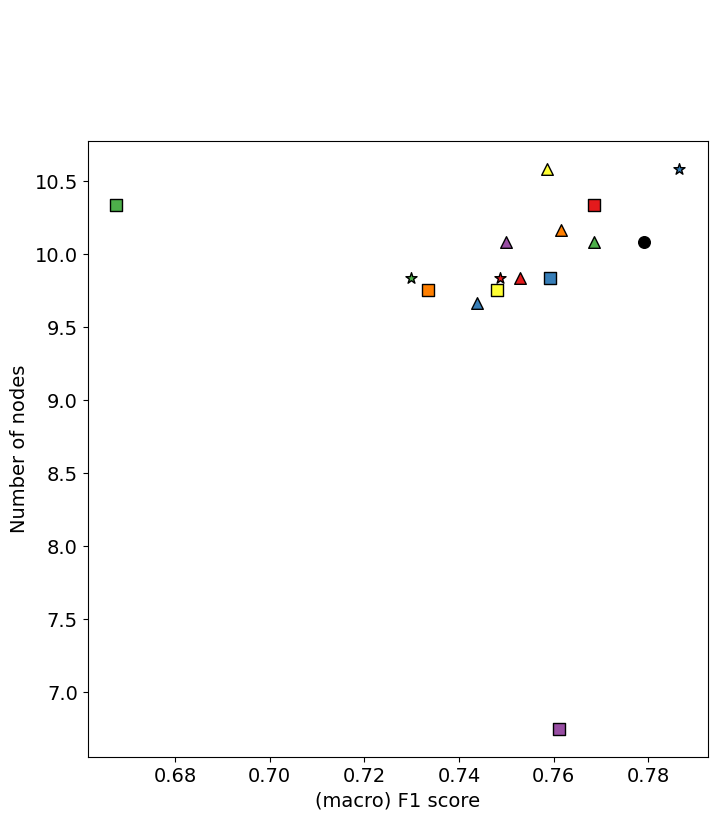

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.figure(figsize=(8, 8))

y_measure = ['resulting_max_depth_test', 'n_nodes_test', 'n_leaf_test'][1]

df_best = df.sort_values(by=["dataset", "method", 'f1_macro_val', y_measure], ascending=[False]*3+[True])\
            .groupby(["dataset", "method"]).head(1).copy()

df_best.resulting_max_depth_test -= 1

df_best = df_best.groupby('method')[['f1_macro_test', y_measure]].mean().reset_index()

texts = []

for i, method in enumerate(viz_dict.keys()):
    row = df_best[df_best['method'] == method]
    if not row.empty:
        f1_macro = row['f1_macro_test'].values[0]
        n_nodes = row[y_measure].values[0]
        label, marker, color = viz_dict[method]

        #if label in ['$\mathrm{PT}$', '$\mathrm{SPPT}$']:
        #    continue

        if i in [0, 1]:
            sns.scatterplot(x=[f1_macro], y=[n_nodes], color='#ffffff')

        sns.scatterplot(x=[f1_macro], y=[n_nodes],
                        marker=(2, 0, 45) if marker == '_' else marker,
                        color=color, s=70, edgecolor='black', linewidth=1)

        #texts.append(plt.text(f1_macro, n_nodes, label, ha='left', va='center', fontsize=14))

#plt.ylim(6.5, 11)

"""adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='black'),
            #force_text=(.5, .5),
            #force_static=(.5, .5),
            expand=(1.4, 1.4)
)"""

plt.legend(loc='center left', bbox_to_anchor=(-.04, 1.2), ncol=6,
           fontsize=14, columnspacing=0.22, frameon=False, handletextpad=-.3)
plt.xlabel('(macro) F1 score', fontsize=14)
plt.ylabel("Number of nodes", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("z_img_2Ablation_depth4_scatter.svg", dpi=800, bbox_inches='tight')
plt.show()


In [24]:
def calcola_media(colonne=list(df_count.columns)):

    df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
                .groupby(["dataset", "method"]).head(1)
    df_count = df_best[colonne]
    media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
    #std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

    return media

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2914135/390442593.py:10: SyntaxWarning: invalid escape sequence '\D'
  df_stump_IG['agg'] = '$\Delta$'
/tmp/ipykernel_2914135/390442593.py:14: SyntaxWarning: invalid escape sequence '\m'
  df_stump_ID['agg'] = '$\mathcal{I}_D$'
/tmp/ipykernel_2914135/390442593.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  bar.set_hatch(hatches[i % len(hatches)])


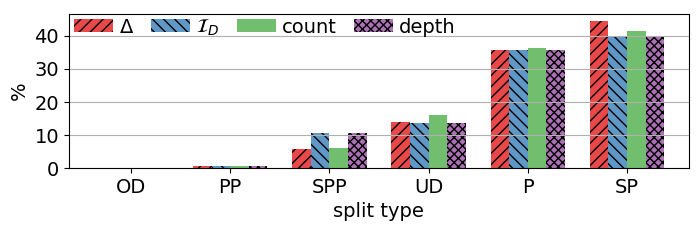

In [28]:
df_stump_count = calcola_media(df_count.columns).reset_index().rename(columns={0: 'value', 'index': 'stump_name'})
df_stump_count['agg'] = 'count'

df_stump_depth = calcola_media(df_count_w.columns).reset_index().rename(columns={0: 'value', 'index': 'stump_name'})
df_stump_depth['stump_name'] = df_stump_depth['stump_name'].apply(lambda x: x.split('_')[0])
df_stump_depth['agg'] = 'depth'

df_stump_IG = calcola_media(df_count_w_info.columns).reset_index().rename(columns={0: 'value', 'index': 'stump_name'})
df_stump_IG['stump_name'] = df_stump_IG['stump_name'].apply(lambda x: x.split('_')[0])
df_stump_IG['agg'] = '$\Delta$'

df_stump_ID = calcola_media(df_count_w.columns).reset_index().rename(columns={0: 'value', 'index': 'stump_name'})
df_stump_ID['stump_name'] = df_stump_ID['stump_name'].apply(lambda x: x.split('_')[0])
df_stump_ID['agg'] = '$\mathcal{I}_D$'

df_stump = pd.concat([df_stump_count, df_stump_depth, df_stump_IG, df_stump_ID])
df_stump.value *= 100

rename_dict={
    'ObliqueDecision': 'OD',
    'MultiplePivot': 'PP',
    'PartialProximity': 'SPP',
    'Decision': 'UD',
    'Pivot': 'P',
    'PartialPivot': 'SP',
}

df_stump.stump_name = df_stump.stump_name.apply(lambda x: rename_dict[x])


ax = df_stump.pivot(columns='agg', index='stump_name', values='value').sort_values(by='count').plot.bar(
    figsize=(8, 2),
    color=colors[:3]+colors[5:],
    alpha=.8,
    width=.75
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

hatches = ['///', '\\\\\\', ' ', 'xxxx']
for i, bars in enumerate(ax.containers):
    for bar in bars:
        bar.set_hatch(hatches[i % len(hatches)])

plt.xlabel('split type', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(
    fontsize=14,
    loc='center left', 
    bbox_to_anchor=(-.02, .91), 
    ncol=4,
    columnspacing=.9,
    frameon=False,
    handletextpad=.3,
)
plt.grid(True, axis='y')
plt.savefig("z_img_2Ablation_depth4_barplot.png", dpi=300, bbox_inches='tight', )
plt.show()

In [ ]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - count')

In [ ]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count_w.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - weighted on node depth')

In [ ]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count_w_info.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - weighted on information gain')

In [ ]:
df_best = df[(df.method == 'HDT')].sort_values(by=["dataset", "method", 'f1_macro_val',], ascending=False)\
            .groupby(["dataset", "method"]).head(1)
df_count = df_best[list(df_count_w_imp.columns)]
media = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).mean().sort_values()
std = df_count.div(df_count.sum(axis=1), axis=0).fillna(0).std()[media.index]

media.plot.bar(yerr=std, capsize=4)
plt.title(f'Overall - weighted on impurity decrease')

In [ ]:
calcola_media(df_count.columns)